### XGBoost Modeling

In [28]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, f1_score
from xgboost import XGBClassifier
import xgboost as xgb
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [29]:
# -----------------------------
# ① 데이터 로드
# -----------------------------
vip_df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\data\\vip_final.csv")

base_features = [
    '총거래금액', '총거래건수', '총예금잔액', '총여신잔액',
    '대출비중', '상품다양성지수', '총카드사용액',
    '외환_수출실적금액', '외환_수입실적금액',
    '외부_여신시설자금', '외부_여신운전자금'
]
static_features = ['법인_고객등급', '전담고객여부']

In [30]:
# -----------------------------
# ② 기준년월 → 분기 단위 집계
# -----------------------------
vip_df['기준년월'] = pd.to_datetime(vip_df['기준년월'], format='%Y%m')
vip_df['기준분기'] = vip_df['기준년월'].dt.to_period('Q')

agg_df = vip_df.groupby(['세그먼트ID', '기준분기']).agg({
    '총거래금액':'mean',
    '총거래건수':'mean',
    '총예금잔액':'mean',
    '총여신잔액':'mean',
    '대출비중':'mean',
    '상품다양성지수':'mean',
    '총카드사용액':'mean',
    '외환_수출실적금액':'mean',
    '외환_수입실적금액':'mean',
    '외부_여신시설자금':'mean',
    '외부_여신운전자금':'mean',
    '법인_고객등급':'first',
    '전담고객여부':'first',
    '이탈여부':'max'  # 분기 내 한번이라도 이탈 시 1
}).reset_index()


In [31]:
# -----------------------------
# ③ (1 - X) 정규화
# -----------------------------
scaler = MinMaxScaler()
for col in base_features:
    agg_df[col] = 1 - scaler.fit_transform(agg_df[[col]])

In [32]:
# -----------------------------
# ④ Lag / Diff / Rolling 생성 함수
# -----------------------------
def create_time_series_features(df, group_col, time_col, feature_cols, lag_list=[1], rolling_windows=[2]):
    df = df.copy()
    df = df.sort_values([group_col, time_col])
    g = df.groupby(group_col)

    for col in feature_cols:
        for lag in lag_list:
            df[f"{col}_lag{lag}"] = g[col].shift(lag)

        if 1 in lag_list:
            df[f"{col}_diff1"] = df[col] - df[f"{col}_lag1"]

        for win in rolling_windows:
            df[f"{col}_roll{win}"] = g[col].transform(lambda x: x.rolling(window=win, min_periods=1).mean())

    return df.fillna(0)

agg_df = create_time_series_features(
    df=agg_df,
    group_col='세그먼트ID',
    time_col='기준분기',
    feature_cols=base_features,
    lag_list=[1],            # 1분기 전
    rolling_windows=[2]      # 최근 2개 분기 평균
)

In [33]:
# -----------------------------
# ⑤ 타겟 shift (미래 이탈 예측)
# -----------------------------
agg_df = agg_df.sort_values(['세그먼트ID', '기준분기'])
agg_df['target_next_quarter'] = agg_df.groupby('세그먼트ID')['이탈여부'].shift(-1)
agg_df = agg_df.dropna(subset=['target_next_quarter'])


In [34]:
# -----------------------------
# ⑥ 피처 목록 구성
# -----------------------------
feature_cols = []
for col in base_features:
    feature_cols += [col, f"{col}_lag1", f"{col}_diff1", f"{col}_roll2"]
feature_cols += static_features

X = agg_df[feature_cols]
y = agg_df['target_next_quarter']

In [35]:
# -----------------------------
# ⑦ TimeSeriesSplit
# -----------------------------
tscv = TimeSeriesSplit(n_splits=4)  # 분기 수에 맞게 조절


In [36]:
# -----------------------------
# ⑧ XGBoost 학습 및 평가
# -----------------------------
auc_scores = []
f1_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc'
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    auc_scores.append(auc)
    f1_scores.append(f1)

    print(f"[Fold {fold+1}] AUC: {auc:.4f}, F1: {f1:.4f}")

print("\n=== 최종 성능 ===")
print(f"평균 AUC: {np.mean(auc_scores):.4f}")
print(f"평균 F1: {np.mean(f1_scores):.4f}")


[Fold 1] AUC: 0.9268, F1: 0.8340
[Fold 2] AUC: 0.8870, F1: 0.7063
[Fold 3] AUC: 0.8526, F1: 0.6502
[Fold 4] AUC: 0.9035, F1: 0.7294

=== 최종 성능 ===
평균 AUC: 0.8924
평균 F1: 0.7300


In [37]:
X

,총거래금액,총거래금액_lag1,총거래금액_diff1,총거래금액_roll2,총거래건수,총거래건수_lag1,총거래건수_diff1,총거래건수_roll2,총예금잔액,총예금잔액_lag1,...,외부_여신시설자금,외부_여신시설자금_lag1,외부_여신시설자금_diff1,외부_여신시설자금_roll2,외부_여신운전자금,외부_여신운전자금_lag1,외부_여신운전자금_diff1,외부_여신운전자금_roll2,법인_고객등급,전담고객여부
0,0.997674,0.000000,0.000000,0.997674,0.786004,0.000000,0.000000,0.786004,0.999168,0.000000,...,0.998820,0.000000,0.000000,0.998820,0.991475,0.000000,0.000000,0.991475,0.920000,1.000000
1,0.998165,0.997674,0.000491,0.997920,0.783829,0.786004,-0.002175,0.784917,0.999443,0.999168,...,0.998718,0.998820,-0.000102,0.998769,0.991210,0.991475,-0.000265,0.991342,0.928571,0.952381
2,0.998402,0.998165,0.000237,0.998284,0.785328,0.783829,0.001498,0.784578,0.999252,0.999443,...,0.998673,0.998718,-0.000046,0.998695,0.991062,0.991210,-0.000148,0.991136,0.931818,0.954545
3,0.997815,0.998402,-0.000587,0.998109,0.782193,0.785328,-0.003135,0.783760,0.999207,0.999252,...,0.998751,0.998673,0.000078,0.998712,0.990920,0.991062,-0.000142,0.990991,0.934783,0.956522
4,0.997503,0.997815,-0.000313,0.997659,0.780137,0.782193,-0.002056,0.781165,0.999304,0.999207,...,0.998720,0.998751,-0.000030,0.998735,0.990813,0.990920,-0.000107,0.990866,0.931818,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5526,0.999629,0.999022,0.000607,0.999325,0.968560,0.941176,0.027383,0.954868,0.999996,0.999995,...,0.544077,0.565321,-0.021244,0.554699,0.084060,0.099486,-0.015427,0.091773,1.000000,1.000000
5527,0.999178,0.999629,-0.000451,0.999404,0.960446,0.968560,-0.008114,0.964503,0.999999,0.999996,...,0.528269,0.544077,-0.015808,0.536173,0.075101,0.084060,-0.008959,0.079580,1.000000,1.000000
5528,0.999347,0.999178,0.000169,0.999263,0.974645,0.960446,0.014199,0.967546,0.999997,0.999999,...,0.510333,0.528269,-0.017935,0.519301,0.035701,0.075101,-0.039400,0.055401,1.000000,1.000000
5529,0.997545,0.999347,-0.001802,0.998446,0.825558,0.974645,-0.149087,0.900101,0.997117,0.999997,...,0.498031,0.510333,-0.012302,0.504182,0.028419,0.035701,-0.007281,0.032060,1.000000,1.000000


In [38]:
# 'model'은 이미 학습된 xgboost 모델 객체라고 가정합니다.
import pandas as pd

# 1. Booster 객체 가져오기 (scikit-learn API로 학습된 경우)
booster = model.get_booster()

# 2. 중요도 점수 가져오기 (기본값은 'weight'입니다. 'gain', 'cover' 등 지정 가능)
importance_scores = booster.get_score(importance_type='gain') 

# 3. 보기 편하게 DataFrame으로 변환 및 정렬
importance_df = pd.DataFrame(
    list(importance_scores.items()), 
    columns=['feature', 'importance']
)
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

            feature  importance
20          상품다양성지수   36.613258
23    상품다양성지수_roll2   26.862679
16             대출비중   18.887596
4             총거래건수   17.448849
19       대출비중_roll2   14.767374
7       총거래건수_roll2   10.746265
11      총예금잔액_roll2    7.490856
8             총예금잔액    6.656311
44          법인_고객등급    5.878215
5        총거래건수_lag1    5.498413
37   외부_여신시설자금_lag1    5.262536
1        총거래금액_lag1    5.142573
31  외환_수출실적금액_roll2    5.085719
43  외부_여신운전자금_roll2    5.061302
3       총거래금액_roll2    4.981102
2       총거래금액_diff1    4.934944
22    상품다양성지수_diff1    4.824490
30  외환_수출실적금액_diff1    4.716934
18       대출비중_diff1    4.682192
15      총여신잔액_roll2    4.654697
9        총예금잔액_lag1    4.535884
33   외환_수입실적금액_lag1    4.299521
39  외부_여신시설자금_roll2    4.249528
40        외부_여신운전자금    4.185971
28        외환_수출실적금액    4.184493
21     상품다양성지수_lag1    4.162864
0             총거래금액    4.145143
45           전담고객여부    4.132745
34  외환_수입실적금액_diff1    4.101014
13       총여신잔액_lag1    4.090485
24      

<Figure size 1000x600 with 0 Axes>

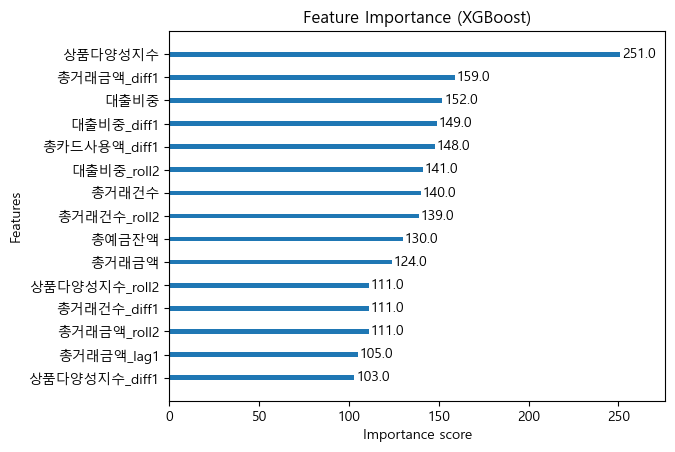

In [39]:
import matplotlib.pyplot as plt
import xgboost as xgb

plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=15) 
ax = plt.gca() # 현재 축(Axes) 객체를 가져옵니다.
ax.grid(False) # 축 객체의 격자 표시를 비활성화합니다.
plt.title('Feature Importance (XGBoost)')
plt.show()

### SHAP 기반 영향 피처 분석 → 마케팅 인사이트 도출

In [40]:
import shap

# XGBoost 분류 모델 기준
explainer = shap.TreeExplainer(model)

# shap_values는 (n_samples, n_features) 형태
# 분류 모델이기 때문에 이탈(1) 클래스에 대한 SHAP값만 선택
shap_values = explainer.shap_values(X)
# 이탈 클래스(1)에 대한 SHAP 값만 사용
shap_values_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values

# DataFrame 변환
shap_df = pd.DataFrame(shap_values_class1, columns=X.columns)

# 이탈 확률 예측값 계산
y_pred_proba = model.predict_proba(X)[:, 1]

# 상위 20% 이탈확률 고객군 인덱스
threshold = np.quantile(y_pred_proba, 0.8)
high_risk_idx = np.where(y_pred_proba >= threshold)[0]

# 상위 위험군의 SHAP값만 추출
shap_high = shap_df.iloc[high_risk_idx]

# 절댓값 기준 평균 영향도 계산
shap_importance = shap_high.abs().mean().sort_values(ascending=False)
top_features = shap_importance.head(15)

print("🚀 상위 15개 영향 피처 (분류 모델 기반):")
print(top_features)

🚀 상위 15개 영향 피처 (분류 모델 기반):
상품다양성지수          1.494764
상품다양성지수_roll2    0.645035
총거래건수            0.417767
대출비중             0.392044
총거래건수_roll2      0.316521
대출비중_roll2       0.234285
총거래금액_diff1      0.214851
총예금잔액            0.210455
총예금잔액_roll2      0.171748
법인_고객등급          0.171525
총거래금액_lag1       0.154283
총거래건수_lag1       0.127579
상품다양성지수_lag1     0.122392
상품다양성지수_diff1    0.118236
총여신잔액_roll2      0.116487
dtype: float32


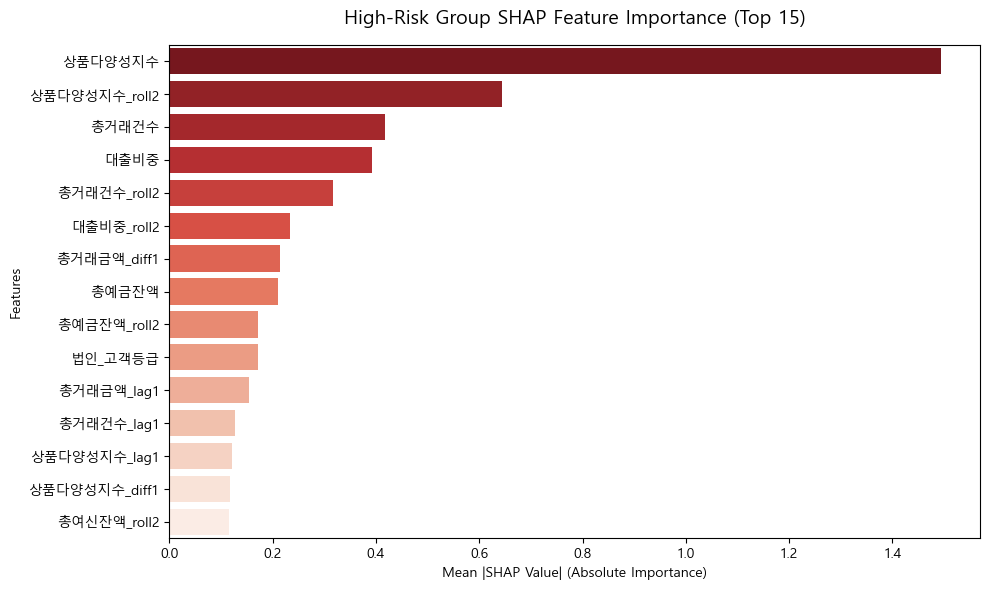

In [22]:
import seaborn as sns

# -------------------------------
# ① 상위 15개 피처 중요도 (절댓값 기준)
# -------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_features.values,
    y=top_features.index,
    orient='h',
    palette='Reds_r'
)
plt.title('High-Risk Group SHAP Feature Importance (Top 15)', fontsize=14, pad=15)
plt.xlabel('Mean |SHAP Value| (Absolute Importance)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [41]:
# 주요 피처 리스트 (앞에서 도출한 상위 15개)
top_features = [
    '상품다양성지수', '상품다양성지수_roll2', '총거래건수', '대출비중', '총거래건수_roll2',
       '대출비중_roll2', '총거래금액_diff1', '총예금잔액', '총예금잔액_roll2', '법인_고객등급',
       '총거래금액_lag1', '총거래건수_lag1', '상품다양성지수_lag1', '상품다양성지수_diff1',
       '총여신잔액_roll2'
]

# 각 피처별 SHAP값 평균 (부호 유지)
feature_direction = shap_high[top_features].mean().sort_values(ascending=False)

print("🚦 상위 15개 피처의 방향성")
print(feature_direction)


🚦 상위 15개 피처의 방향성
상품다양성지수          1.359410
상품다양성지수_roll2    0.577982
대출비중             0.335632
총거래건수            0.307443
대출비중_roll2       0.213015
총거래건수_roll2      0.193217
총예금잔액            0.129219
총예금잔액_roll2      0.120369
상품다양성지수_lag1     0.103066
총거래금액_lag1       0.083693
총거래건수_lag1       0.080236
상품다양성지수_diff1    0.037075
총여신잔액_roll2      0.023323
총거래금액_diff1      0.009423
법인_고객등급         -0.035161
dtype: float32


=== Top 1 고위험 고객 ===
세그먼트 ID : 도매 및 소매업_도매 및 상품 중개업_경기도_용인시 처인구
예측 이탈확률 : 0.997



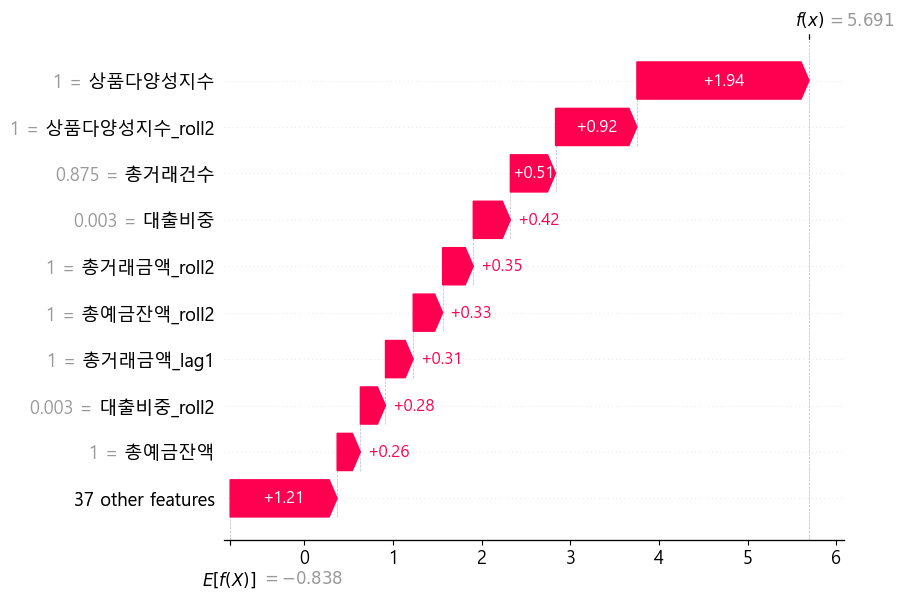

In [24]:
# 이탈확률 예측
y_pred_proba = model.predict_proba(X)[:, 1]

# 예측확률 기준 상위 1개 고객 인덱스 추출
top1_idx = np.argsort(y_pred_proba)[-1]

# 원본 DataFrame과 매칭 (vip_df_ts에 세그먼트ID가 있다고 가정)
segment_id = vip_df.iloc[top1_idx]['세그먼트ID']
prob = y_pred_proba[top1_idx]

print(f"=== Top 1 고위험 고객 ===")
print(f"세그먼트 ID : {segment_id}")
print(f"예측 이탈확률 : {prob:.3f}\n")

# Waterfall Plot 시각화
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[top1_idx],
        base_values=explainer.expected_value,
        data=X.iloc[top1_idx, :],
        feature_names=X.columns
    )
)

### Feature Select

In [25]:
import numpy as np
import pandas as pd
import shap

# SHAP 값 다시 계산 (이미 했다면 생략 가능)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 피처별 중요도 평균 절대값 계산
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

# 상위 N개 선택
top_n = 15
top_features = importance_df['feature'].head(top_n).tolist()

print(f"SHAP Top {top_n} Features:")
print(top_features)

SHAP Top 15 Features:
['상품다양성지수', '대출비중', '상품다양성지수_roll2', '총거래건수', '총예금잔액', '대출비중_roll2', '총거래건수_roll2', '총거래금액_diff1', '법인_고객등급', '총예금잔액_roll2', '총여신잔액_roll2', '총거래금액_lag1', '상품다양성지수_diff1', '총카드사용액', '총카드사용액_diff1']


In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, f1_score

X_top = X[top_features]
tscv = TimeSeriesSplit(n_splits=5)

auc_scores = []
f1_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_top)):
    X_train, X_test = X_top.iloc[train_idx], X_top.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model_top = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc'
    )
    model_top.fit(X_train, y_train)

    y_pred = model_top.predict(X_test)
    y_pred_proba = model_top.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    auc_scores.append(auc)
    f1_scores.append(f1)

    print(f"[Fold {fold+1}] AUC: {auc:.4f}, F1: {f1:.4f}")

print(f"\nTop {top_n} Features 평균 AUC: {np.mean(auc_scores):.4f}")
print(f"Top {top_n} Features 평균 F1: {np.mean(f1_scores):.4f}")

[Fold 1] AUC: 0.9271, F1: 0.8333
[Fold 2] AUC: 0.8854, F1: 0.7538
[Fold 3] AUC: 0.8964, F1: 0.6763
[Fold 4] AUC: 0.8545, F1: 0.6898
[Fold 5] AUC: 0.9058, F1: 0.7138

Top 15 Features 평균 AUC: 0.8938
Top 15 Features 평균 F1: 0.7334
